# Another round of sanity  checks

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmasher as cmr

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.stats import bootstrap
import astropy.units as u

from PIL import Image
from matplotlib.colors import LogNorm

import os
from pathlib import Path
import requests
from tqdm.notebook import tqdm

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

ROOT = Path('..').resolve()
results_dir = ROOT/'results/'
fig_dir = results_dir/'xSAGA-medium/figures/'

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

In [83]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [12]:
adf = pd.read_csv(results_dir/'predictions-dr9.csv', index_col='objID')
sdf = adf[adf.p_CNN > 0.5].copy()

adf.shape, sdf.shape

((4433095, 6), (116139, 6))

In [78]:
def load_NSA():
    """Returns dataframe with some NSA info.
    """
    nsa = fits.getdata(ROOT/'data/nsa_v1_0_1.fits')

    # do this column by column, *not* on entire catalog
    byteorder = lambda x: x.byteswap().newbyteorder()

    # doesn't use .byteswap().newbyteorder() because that's super slow...
    return pd.DataFrame({
        'NSAID': byteorder(nsa.NSAID),
        'z_NSA': byteorder(nsa.Z),
        'ra_NSA': byteorder(nsa.RA),
        'dec_NSA': byteorder(nsa.DEC),
        'M_r_NSA': byteorder(nsa.ELPETRO_ABSMAG[:, 4]),
        'mass_NSA': byteorder(nsa.ELPETRO_MASS)
    })

nsa = load_NSA().set_index('NSAID')

In [79]:
# other data products created below

# Section 3.1 (NSA crossmatch with satellites)
sat_x_nsa = pd.read_csv(results_dir/'xSAGA-medium/sat_x_NSA.csv', index_col=0)

# Section 4.2 (hosts, corrected for self-matches)
host_df = pd.read_csv(results_dir/'xSAGA-medium/host_df.csv', index_col=0)

# Section 6 (satellites, assigned to hosts, crossmatched with NSA)
shdf = pd.read_csv(results_dir/'xSAGA-medium/sats_hosts_x_nsa.csv', index_col=0)

# The big picture

In [ ]:
plt.figure(figsize=(12, 8), dpi=300)
plt.scatter(adf.ra, adf.dec, edgecolor='none', s=0.1, c='k', alpha=0.1)

sc = plt.scatter(sdf.ra, sdf.dec, c=sdf.p_CNN, edgecolor='none', s=(sdf.r0/20)**-4, cmap='cmr.ember_r', vmin=0.5, vmax=1.)

plt.colorbar(sc, label='Satellite probability')

plt.xlim(240, 120)
plt.ylim(0, 60)

plt.xlabel('RA')
plt.ylabel('Dec');

plt.savefig(fig_dir/'positions-satellites.png')

# NSA crossmatch

In [27]:
sdf.dropna(inplace=True)
sdf.shape

(116124, 6)

In [20]:
nsa = fits.getdata(ROOT/'data/nsa_v1_0_1.fits')

nsa_z = nsa.Z
nsa_ra = nsa.RA
nsa_dec = nsa.DEC
nsa_mag = nsa.ELPETRO_ABSMAG[:, 4]

nsa_lowz = nsa_z < 0.03


In [28]:
nsa_coords_lowz = SkyCoord(nsa_ra[nsa_lowz], nsa_dec[nsa_lowz], unit='deg')
sat_coords = SkyCoord(sdf.ra, sdf.dec, unit='deg')

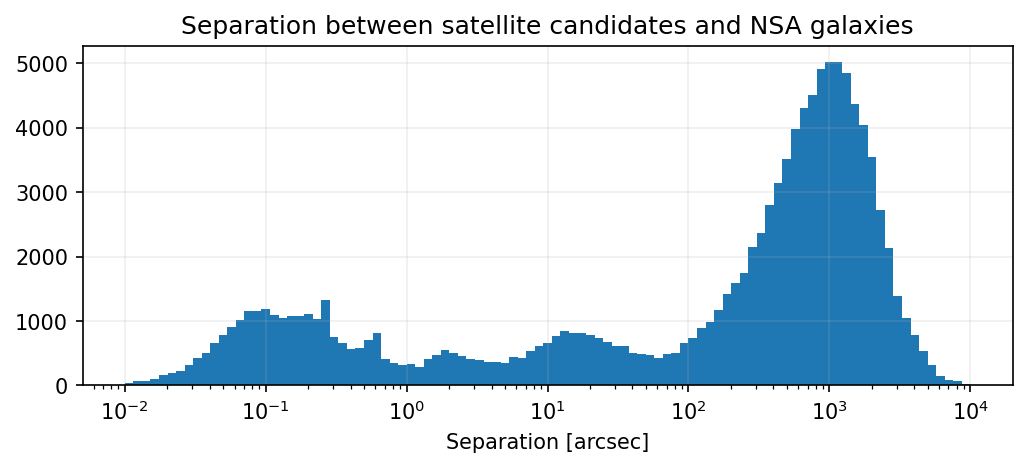

In [29]:
nsa_idx, sep, _ = sat_coords.match_to_catalog_sky(nsa_coords_lowz)
sep = sep.to('arcsec').value

plt.figure(figsize=(8,3), dpi=150)
plt.hist(sep, bins=np.logspace(-2, 4, num=100))
plt.xscale('log')
plt.xlabel('Separation [arcsec]')
plt.title('Separation between satellite candidates and NSA galaxies')
plt.grid(alpha=0.2);

These bumps in the distribution are probably

| Ang dist ["] | Dist [pkpc] at z=0.02 | Description                     |
|--------------|-----------------------|---------------------------------|
| $\sim 0.1$   | 0.04                  | NSA-satellite self-matches      |
| $\sim 2$     | 0.8                   | Also self-matches (?)           |
| $\sim 20$    | 8                     | Shredded low-$z$ host matches   | 
| $\sim 1000$  | 400                   | Actual satellite-host matches   |

For now, we'll reject the shreds using a constant 60 arcsec cut.

In [30]:
len(nsa_idx), len(np.unique(nsa_idx)), len(np.unique(nsa_idx[sep>60]))

(116124, 38564, 28066)

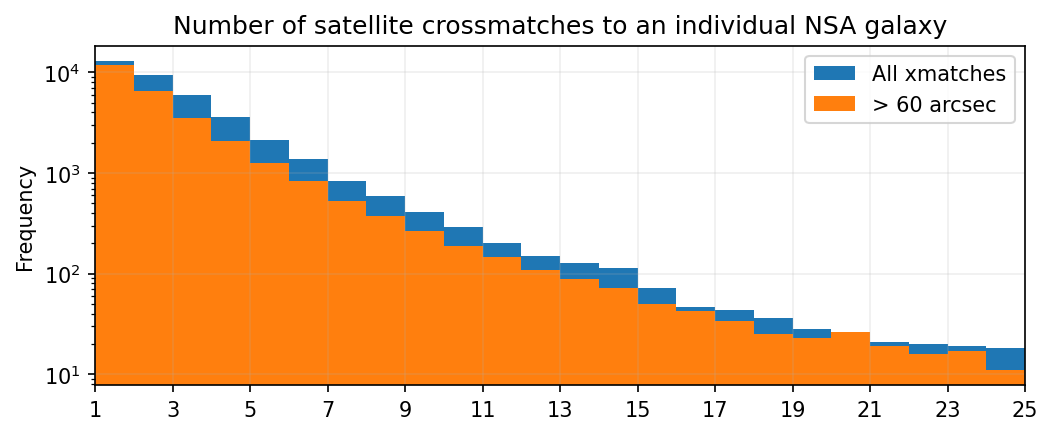

In [45]:
plt.figure(figsize=(8,3), dpi=150)
pd.Series(nsa_idx).value_counts().plot.hist(bins=25, range=(1,26), log=True, label='All xmatches')
pd.Series(nsa_idx[sep>60]).value_counts().plot.hist(bins=25, range=(1,26), log=True, label='> 60 arcsec')

plt.xlim(1, 25);
plt.xticks(np.arange(1, 26, 2))
plt.title('Number of satellite crossmatches to an individual NSA galaxy')
plt.legend()
plt.grid(alpha=0.2)

plt.savefig(fig_dir/'nsa-satellite-number_of_crossmatches.png')

## Save crossmatches as `sat_x_nsa`

In [46]:
sat_x_nsa = sdf.copy()

sat_x_nsa['z_NSA'] = nsa_z[nsa_lowz][nsa_idx]
sat_x_nsa['M_r_NSA'] = nsa_mag[nsa_lowz][nsa_idx]
sat_x_nsa['sep_NSA'] = sep
sat_x_nsa['ra_NSA'] = nsa_ra[nsa_lowz][nsa_idx]
sat_x_nsa['dec_NSA'] = nsa_dec[nsa_lowz][nsa_idx]

sat_x_nsa.sample(10, random_state=42)

p_CNN          ra        dec        g0        r0  \
objID                                                                      
1237666463192908087  0.635811  120.802370  65.311918  17.24775  17.09686   
1237651736313987722  0.678116  226.078874   1.755383  18.19375  17.61009   
1237662195068174371  0.783533  199.697972  41.942603  20.53529  20.59862   
1237658612513374258  0.996719  154.969513  45.554685  13.86206  13.88730   
1237668332033867806  0.858927  233.738090  11.742631  20.05388  19.69413   
1237667550344970448  0.587800  164.561377  23.413925  15.84125  15.23272   
1237667538000085861  0.534953  133.196314  16.285791  20.39425  20.23060   
1237651735757258774  0.978411  180.674897   1.980598  14.56962  14.97351   
1237661949730226306  0.953022  214.220625  10.807425  12.50191  11.65676   
1237661852548333784  0.686901  201.839601  44.842509  20.21545  20.24040   

                         R_eff     z_NSA    M_r_NSA      sep_NSA      ra_NSA  \
objID                                                                          
1237666463192908087   3.223088  0.016388 -20.119474  4587.292818  119.339115   
1237651736313987722   8.070174  0.006127 -16.359915   845.954397  226.035268   
1237662195068174371   1.070660  0.004162 -17.095476    36.857233  199.688077   
1237658612513374258  26.679640  0.002226 -19.309755    29.781533  154.979024   
1237668332033867806   2.146475  0.006302 -19.039938    34.290192  233.743916   
1237667550344970448   5.052895  0.021248 -16.564194  1010.792678  164.567436   
1237667538000085861   2.061640  0.029655 -17.644138   798.054018  133.268867   
1237651735757258774  22.003270  0.006542 -20.048975    14.251140  180.676020   
1237661949730226306  14.396340  0.024712 -22.456387     0.071821  214.220637   
1237661852548333784   2.078356  0.027888 -20.544394   273.749583  201.736717   

                       dec_NSA  
objID                           
1237666463192908087  66.437175  
1237651736313987722   1.524474  
1237662195068174371  41.949721  
1237658612513374258  45.549779  
1237668332033867806  11.750259  
1237667550344970448  23.694646  
1237667538000085861  16.075344  
1237651735757258774   1.976802  
1237661949730226306  10.807410  
1237661852548333784  44.821094

In [48]:
# sat_x_nsa.to_csv(results_dir/'xSAGA-medium/sat_x_NSA.csv', index=True)

## Visualize sats and (NSA) hosts

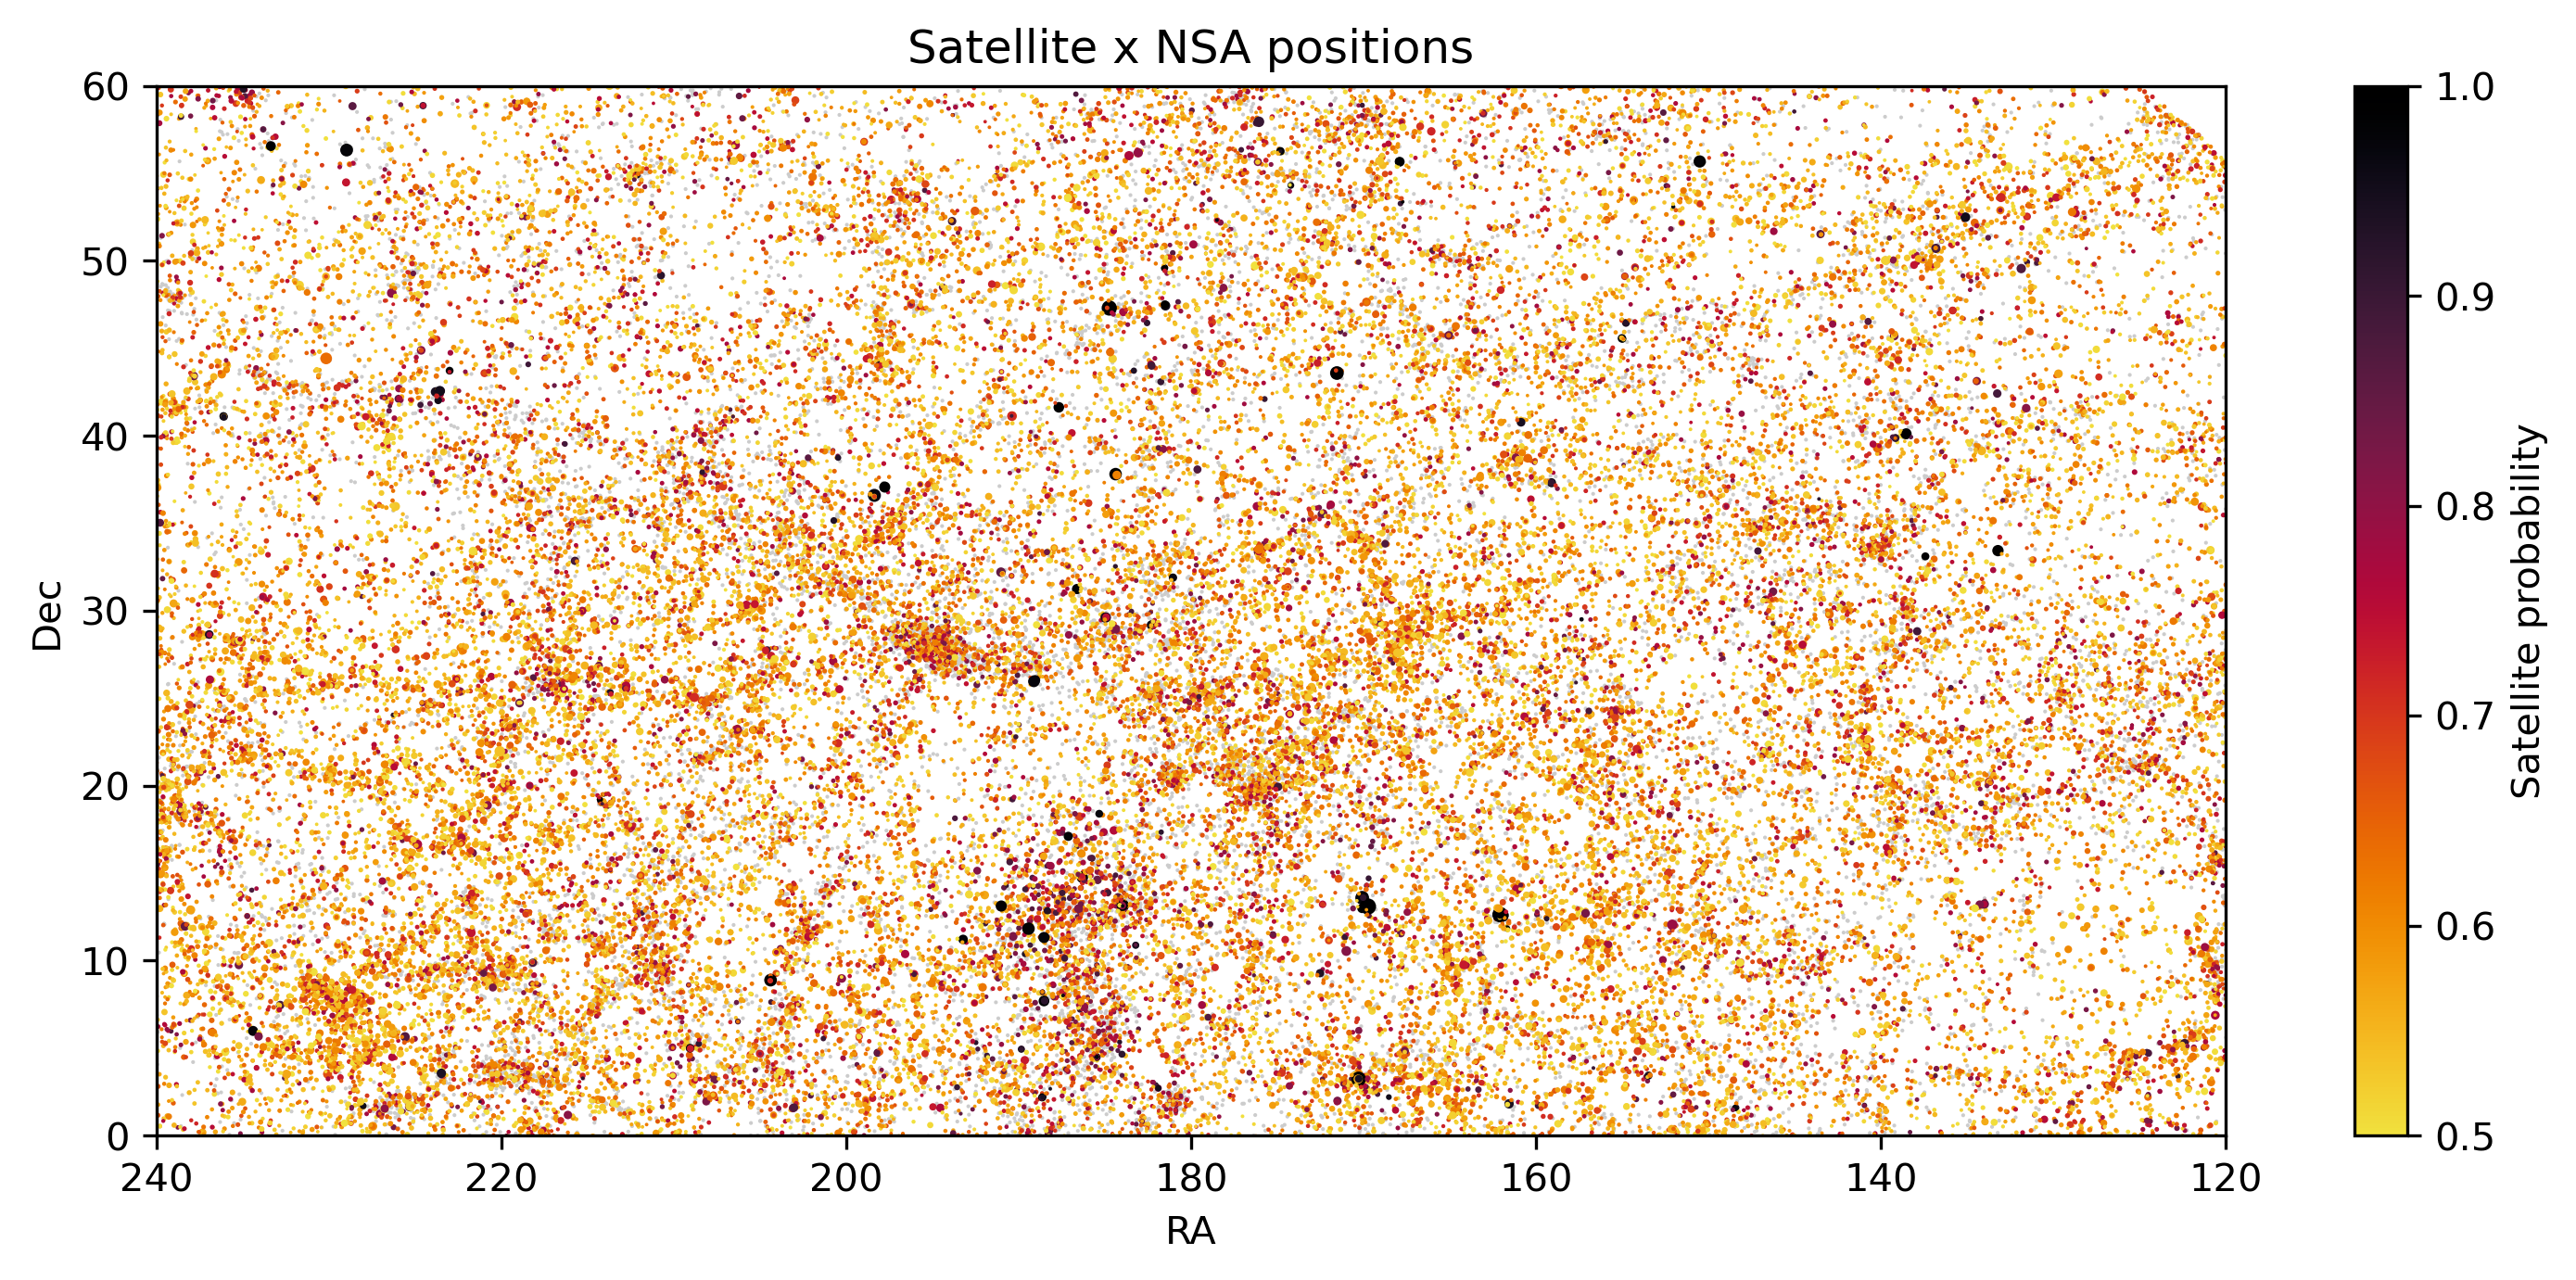

In [53]:
plt.figure(figsize=(12, 5), dpi=300)

xmatch = (sat_x_nsa.sep_NSA < 1.).values  # hosts
smatch = (sat_x_nsa.sep_NSA > 60.).values # satellites
plt.scatter(sat_x_nsa[xmatch].ra, sat_x_nsa[xmatch].dec, c='0.8', edgecolor='none', s=1)

sc = plt.scatter(sat_x_nsa[smatch].ra, sat_x_nsa[smatch].dec, c=sat_x_nsa[smatch].p_CNN, edgecolor='none', s=(sat_x_nsa[smatch].r0/20)**-4, cmap='cmr.ember_r', vmin=0.5, vmax=1.)
plt.colorbar(sc, label='Satellite probability')

plt.xlim(240, 120)
plt.ylim(0, 60)      


plt.title('Satellite x NSA positions')
plt.xlabel('RA')
plt.ylabel('Dec');

In case you're wondering what's going on around RA, Dec = (187, 11), that's basically the Virgo cluster! The overdensity near (195, 28.5) is the Coma cluster. The cluster around (176, 20) is the Leo cluster (never heard of it), and the cluster around (230, 8.5) is Abell 2063.

## Visualize some high-probability sources

Using Yao's tool: https://yymao.github.io/decals-image-list-tool/

In [66]:
# NSA crossmatches
(sat_x_nsa[(sat_x_nsa.sep_NSA < 1) & (sat_x_nsa.r0 > 19)]
 .sort_values('p_CNN', ascending=False)[['ra', 'dec']]
 .head(20)
)

ra        dec
objID                                     
1237650760242233507  178.131647  -3.673640
1237678600231715120    0.522883  16.588958
1237660344469487779  135.117668  35.669417
1237659119327969469  229.812496  44.916047
1237661351631716611  177.374137  56.031490
1237667444581400597  184.180271  28.731013
1237667911132446909  190.850433  24.524087
1237657855536005240  179.508853  51.349393
1237661976547557547  185.770161   8.333256
1237668349749428363  221.599169  14.215486
1237650804808482931  160.838129  -2.135472
1237655369279799402  148.729354  56.607721
1237658493895966745  193.896435  10.739011
1237651821100073091  218.951873   3.038362
1237671764247839207  190.964110  -4.265772
1237661951330353346  189.736307  13.550220
1237662500011442448  250.088269  28.766294
1237661957223350521  209.329374  48.571727
1237661852549120214  204.308119  44.590908
1237658491207155964  183.556513   8.908293

In [63]:
# farther away... (almost everything is shredded though)
(sat_x_nsa[(sat_x_nsa.sep_NSA > 600) & (sat_x_nsa.r0 > 19)]
 .sort_values('p_CNN', ascending=False)[['ra', 'dec']]
 .head(20)
)

ra        dec
objID                                     
1237667781773099469  214.347658  19.200562
1237667781773099472  214.349604  19.196872
1237667782309839746  214.045674  19.481861
1237658629159518245  189.447217  11.826169
1237658629159452801  189.425419  11.827075
1237661813878947928  169.726846  13.111381
1237658629159452807  189.415170  11.819433
1237668273513824408  213.978477  18.805455
1237648704579174453  188.163594   0.113617
1237657771247403136  152.025639  53.091211
1237659343736471604  188.601448   8.206289
1237661950790991930  183.981948  13.176850
1237654786779840632  187.422464   8.003889
1237648675068379425  242.491744   0.713811
1237654786779840631  187.422549   8.011306
1237657070089011207   35.633162  -0.609576
1237671685327552591  174.065219  70.513575
1237664130484994139  170.031562  13.594196
1237660961331019863  143.574108  36.386946
1237657070089011208   35.632522  -0.609223

In [71]:
# pretty good candidates! these have something like `p_CNN` ~ 0.75
(sat_x_nsa[(sat_x_nsa.sep_NSA > 60) & (sat_x_nsa.r0 > 19)]
 .sort_values('p_CNN', ascending=False)[['ra', 'dec']]
 .iloc[1000:1020]
)

ra        dec
objID                                     
1237654030330364460  175.654143   2.875546
1237665330385387874  174.625884  32.154821
1237651736849875313  223.789653   2.310156
1237654871597187278  125.192400  -1.417642
1237648720160489935  187.977492  -0.968134
1237649919501599227   12.637436  14.627837
1237668495242625543  170.313927  16.581879
1237674649929384568  181.587529  -0.290299
1237648721771758080  189.452309   0.319655
1237661951346344243  227.042076  10.604626
1237658424088068356  153.999645   6.800743
1237662236394193264  188.480469   9.081994
1237662700788580585  241.567269  55.430157
1237671764787200338  190.848651   1.409170
1237671264419512637  192.260725  -7.936828
1237656496185475506  355.432386  15.255826
1237667111720059351  136.030649  21.914547
1237660961324335806  128.317611  28.102158
1237671990271345027  207.924165  -6.466373
1237649920044827109   27.622746  13.973913

In [76]:
# still pretty convincing `p_CNN` ~ 0.65
(sat_x_nsa[(sat_x_nsa.sep_NSA > 60) & (sat_x_nsa.r0 > 19)]
 .sort_values('p_CNN', ascending=False)[['ra', 'dec']]
 .iloc[5000:5020]
)

ra        dec
objID                                     
1237659897788957240  267.735222  47.411792
1237665126948602450  224.911611  26.995012
1237657874866962795  142.957226  42.204768
1237665583258468673  258.389949  41.361327
1237678433256014531    9.972348   3.182691
1237652947453739530    4.258965 -10.199738
1237664871362003322  145.884817  33.449347
1237664854174597583  198.097571  37.616155
1237666339724656917   13.813131   0.241030
1237662339473342853  234.149724  29.892790
1237678439703511559   46.137733   3.000376
1237663547973173686  117.917783  47.755837
1237653502045061387   41.052630  -7.882276
1237667211583488141  135.842907  20.820182
1237651212288917988  260.245604  54.824177
1237662199349969171  210.737566  11.486738
1237656241707286951  356.053467  14.619101
1237665367429480598  158.042922  28.674412
1237667782824428353  159.759986  20.566676
1237661957763564012  219.976569  46.167689

# Assign sats to hosts

## Examine separations

In [80]:
sat_coords = SkyCoord(sat_x_nsa.ra, sat_x_nsa.dec, unit='deg')

nsa = load_NSA().set_index('NSAID')
nsa_coords = SkyCoord(nsa.ra_NSA, nsa.dec_NSA, unit='deg')

_, angsep, _ = nsa_coords.match_to_catalog_sky(sat_coords)

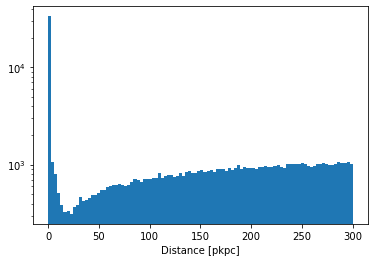

In [107]:
# separations in projected kpc
sep = (cosmo.angular_diameter_distance(nsa.z_NSA).to(u.kpc) * angsep.to(u.rad)).value

# plot distribution of satellite-host separations for hosts at z > 0.005
plt.hist(sep[(nsa.z_NSA > 0.005)], bins=100, range=[0, 300], log=True);
plt.xlabel('Distance [pkpc]');

Cut out satellite candidates separated **< 25 kpc** or **>300 kpc** from an NSA host.

Also, we'll only consider **hosts with stellar mass** > $10^9$ (and less than $10^{14}$) solar masses. 

This is a bit under the mass of the SMC...


In [108]:
hosts = nsa[sep < 300].copy()
hosts = hosts[(hosts.mass_NSA < 1e14) & (hosts.mass_NSA > 1e9) & (hosts.z_NSA < 0.03) & (hosts.z_NSA > 0.005)].copy()

hosts.sort_values('mass_NSA', ascending=False, inplace=True)

len(hosts)

20927

## Perform halo-sat assignment, `host_df`, corrected for self-matches

Start with most massive hosts and work our way down, but now keep track of which host each satellite goes in. Save these host NSAIDs to the satellite dataframe.

In [124]:
host_dict = dict()

host_NSAID = -1 * np.ones(len(sat_x_nsa), dtype=int)
distances = -1 * np.ones(len(sat_x_nsa), dtype=float)

for host in tqdm(hosts.itertuples(), total=len(hosts)):
    nsaid, z, ra, dec, M_r, mass = host
    
    host_coords = SkyCoord(ra, dec, unit='deg')
    host_sep = host_coords.separation(sat_coords)
    
    kpc_per_deg = cosmo.angular_diameter_distance(z).to(u.kpc).value * np.pi / 180 

    # note: could change 300 kpc to something that scales with host mass 
    in_host = (host_sep.to(u.deg).value * kpc_per_deg < 300) & (host_sep.to(u.deg).value * kpc_per_deg > 25)
    new_idxs = in_host & (host_NSAID == -1)    
    
    new_sats_in_host = sat_x_nsa[new_idxs]
    
    host_NSAID[new_idxs] = nsaid 
    distances[new_idxs] = host_sep[new_idxs] * kpc_per_deg
    
    n_sat_in_300kpc = len(new_sats_in_host)
    host_dict[nsaid] = [ra, dec, z, M_r, mass, n_sat_in_300kpc]


In [125]:
host_df = pd.DataFrame.from_dict(
    host_dict, 
    orient='index', 
    columns=['ra', 'dec', 'z', 'M_r', 'mass', 'n_sat_in_300kpc'],
)
host_df.index.name = 'NSAID'
host_df.sample(5, random_state=42)

ra        dec         z        M_r          mass  \
NSAID                                                              
446565  172.873541  35.895219  0.024274 -17.825983  1.092958e+09   
489020  132.073674  16.959288  0.028382 -19.498116  5.867899e+09   
121632  330.454941  13.638136  0.024767 -19.258118  5.474809e+09   
620286   44.118168   4.610461  0.027072 -20.481339  1.570739e+10   
152608  203.999721   3.639137  0.022775 -18.178537  1.169333e+09   

        n_sat_in_300kpc  
NSAID                    
446565                2  
489020                0  
121632                1  
620286                0  
152608                2

Save progress

In [126]:
# host_df.to_csv(results_dir/'xSAGA-medium/host_df.csv')

# Host-satellite occupation

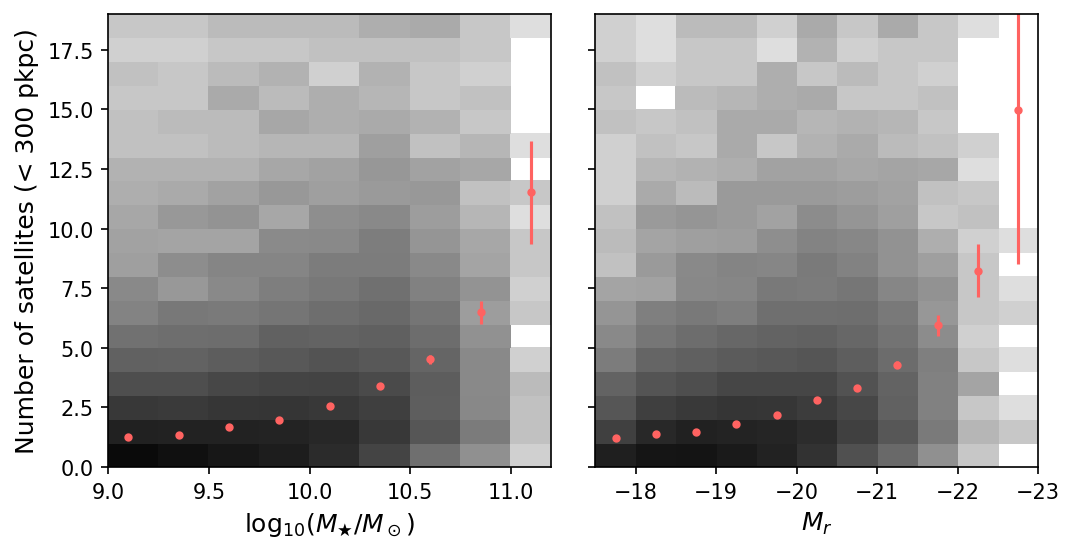

In [155]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True)

# plot stellar mass
mass_bins = np.arange(9., 11.5, 0.25)
ax1.hist2d(host_df.mass.apply(np.log10), host_df.n_sat_in_300kpc, bins=(mass_bins, np.arange(0, 20)), cmap='Greys', norm=LogNorm(0.1, 3e3))

boot_n_sat = np.array([
    bootstrap(
        host_df.n_sat_in_300kpc[(host_df.mass > 10**m1) & (host_df.mass < 10**m2)].values,
        bootfunc=np.mean,
    ) for m1, m2 in zip(mass_bins[:-1], mass_bins[1:])]
)

ax1.errorbar(mass_bins[:-1]+0.1, boot_n_sat.mean(1), boot_n_sat.std(1), c=c3, marker='o', ls='', markersize=3)

ax1.set_xlim(9.0, 11.2)
ax1.set_ylim(-0.5, 20.5)
ax1.set_xlabel(r'$\log_{10}(M_★/M_\odot)$', fontsize=12)
ax1.set_ylabel('Number of satellites (< 300 pkpc)', fontsize=12);

# plot abs mag
mag_bins = np.arange(-23., -17, 0.5)

ax2.hist2d(host_df.M_r, host_df.n_sat_in_300kpc, edgecolors='none', bins=(mag_bins, np.arange(0, 20)), cmap='Greys', norm=LogNorm(0.1, 3e3))

boot_n_sat = np.array([
    bootstrap(
        host_df.n_sat_in_300kpc[(host_df.M_r > mag1) & (host_df.M_r < mag2)].values,
        bootfunc=np.mean,
    ) for mag1, mag2 in zip(mag_bins[:-1], mag_bins[1:])]
)
ax2.errorbar(mag_bins[:-1]+.25, boot_n_sat.mean(1), boot_n_sat.std(1), c=c3, marker='o', ls='', markersize=3)

ax2.set_xlim(-17.5, -23.)
ax2.set_xlabel(r'$M_{r}$', fontsize=12)

fig.subplots_adjust(wspace=0.1)

plt.savefig(fig_dir/'nsats-per-host.png')

# Radial distribution of satellites

In [167]:
sat_x_nsa['host_distance'] = distances
sat_x_nsa['host_NSAID'] = host_NSAID

shdf = sat_x_nsa.join(hosts, on='host_NSAID', how='left', rsuffix='_HOST')

In [169]:
# sats-hosts_x_nsa
# shdf.to_csv(results_dir/'xSAGA-medium/sats_hosts_x_nsa.csv')

## Mass bins [9, 9.5, 10, 10.5, 11]

9995 7673
12618 6840
14871 5098
6278 1264
513 49


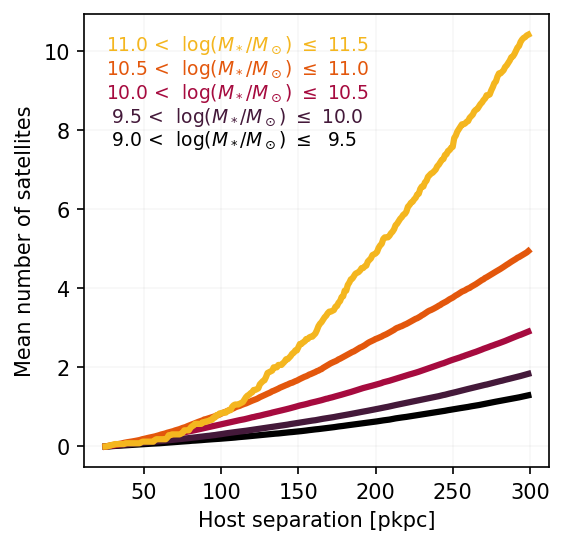

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

radius_range = np.arange(25, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(
    zip(
        np.arange(9, 11.5, 0.5), 
        np.arange(9.5, 12, 0.5), 
        cmr.ember(np.linspace(0, 0.9, 5)), 
    )
):

    in_mass_range = (shdf.mass_NSA > 10**m1) & (shdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(shdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat, color=color, lw=3)
    
    ax.text(25, 7.75+i*0.6, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

plt.savefig(fig_dir/'satellite-radial-distribution_a.png')

## Mass bins [9, 9.4, 9.8, 10.2, 10.6, 11, 11.4]

8141 6244
8984 5585
11468 5074
10974 3216
4195 756
512 48


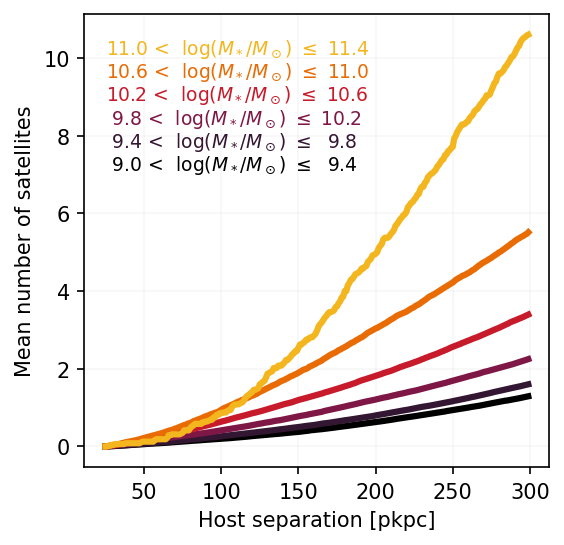

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

radius_range = np.arange(25, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(
    zip(
        np.arange(9, 11.4, 0.4), 
        np.arange(9.4, 11.8, 0.4), 
        cmr.ember(np.linspace(0, 0.9, 6)), 
    )
):

    in_mass_range = (shdf.mass_NSA > 10**m1) & (shdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(shdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat, color=color, lw=3)
    
    ax.text(25, 7.25+i*0.6, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

plt.savefig(fig_dir/'satellite-radial-distribution_b.png')

## Mass bins [9, 9.25, ... 11.25]

5051 4046
4944 3627
5846 3459
6772 3381
7521 2931
7350 2167
4447 981
1831 283
495 43


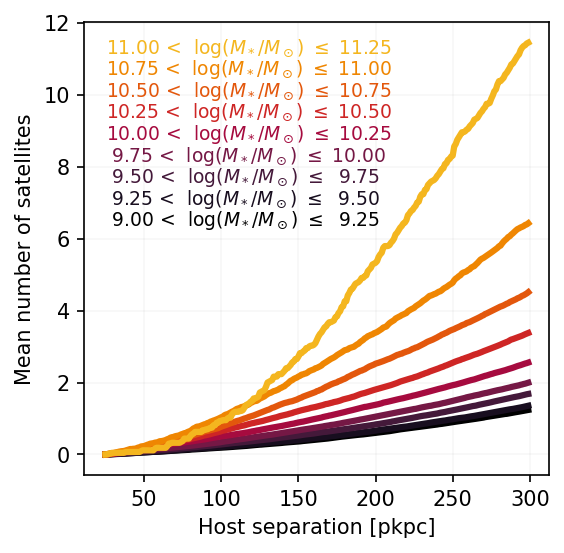

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

radius_range = np.arange(25, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(
    zip(
        np.arange(9, 11.25, 0.25), 
        np.arange(9.25, 11.5, 0.25), 
        cmr.ember(np.linspace(0, 0.9, 9)), 
    )
):

    in_mass_range = (shdf.mass_NSA > 10**m1) & (shdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(shdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat, color=color, lw=3)
    
    ax.text(25, 6.5+i*0.6, f'{m1:>5.2f} <  log($M_*/M_\odot$) $\leq$ {m2:>5.2f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Mean number of satellites')

ax.grid(alpha=0.1)

plt.savefig(fig_dir/'satellite-radial-distribution_c.png')

# Normalized radial distributions

## Normalized to the number at 300 kpc

8141 6244
8984 5585
11468 5074
10974 3216
4195 756
512 48


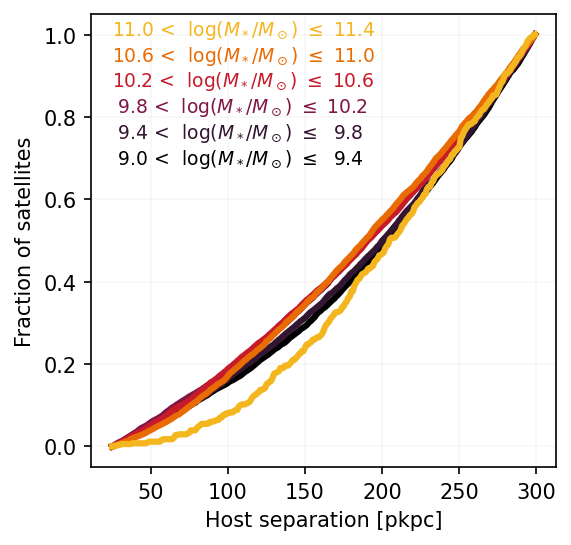

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

radius_range = np.arange(25, 300, 1)

for i, (m1, m2, color) in enumerate(
    zip(
        np.arange(9, 11.4, 0.4), 
        np.arange(9.4, 11.8, 0.4), 
        cmr.ember(np.linspace(0, 0.9, 6)), 
    )
):

    in_mass_range = (shdf.mass_NSA > 10**m1) & (shdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(shdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat / cdf_sat.max(), color=color, lw=3)
    
    ax.text(25, 0.7+i/16, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Fraction of satellites')

ax.grid(alpha=0.1)

plt.savefig(fig_dir/'normalized_satellite-radial-distribution_a.png')

8141 6244
8984 5585
11468 5074
10974 3216
4195 756
512 48


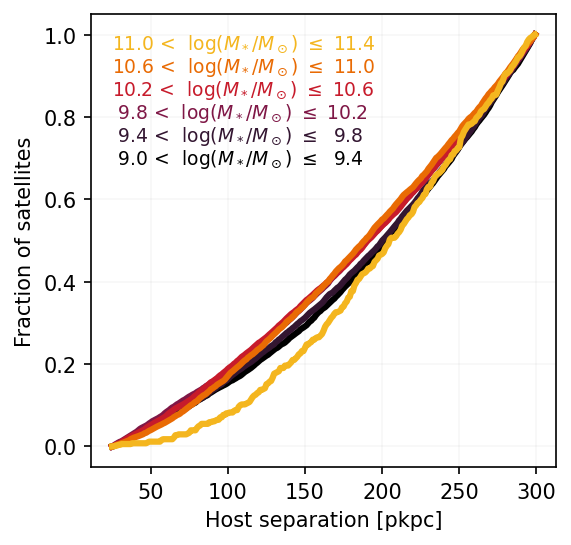

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

radius_range = np.arange(25, 300, 1)

for i, (m1, m2, color) in enumerate(
    zip(
        np.arange(9, 11.4, 0.4), 
        np.arange(9.4, 11.8, 0.4), 
        cmr.ember(np.linspace(0, 0.9, 6)), 
    )
):

    in_mass_range = (shdf.mass_NSA > 10**m1) & (shdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(shdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat / cdf_sat.max(), color=color, lw=3)
    
    ax.text(25, 0.7+i/18, f'{m1:>4.1f} <  log($M_*/M_\odot$) $\leq$ {m2:>4.1f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Fraction of satellites')

ax.grid(alpha=0.1)

plt.savefig(fig_dir/'normalized_satellite-radial-distribution_b.png')

5051 4046
4944 3627
5846 3459
6772 3381
7521 2931
7350 2167
4447 981
1831 283
495 43


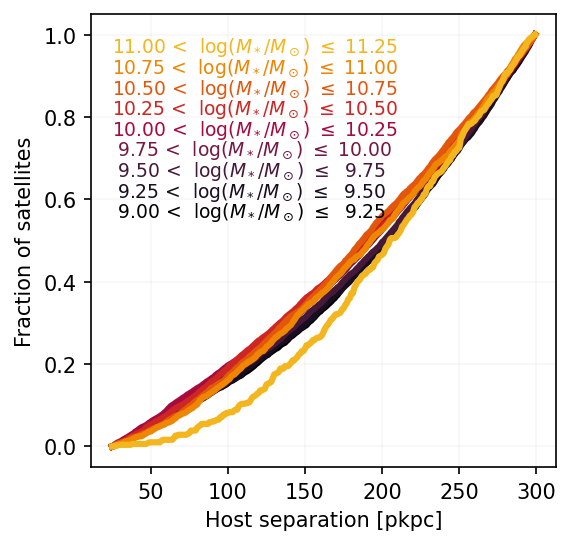

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

radius_range = np.arange(25, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(
    zip(
        np.arange(9, 11.25, 0.25), 
        np.arange(9.25, 11.5, 0.25), 
        cmr.ember(np.linspace(0, 0.9, 9)), 
    )
):

    in_mass_range = (shdf.mass_NSA > 10**m1) & (shdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(shdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat / cdf_sat.max(), color=color, lw=3)
    
    ax.text(25, 0.57+i/20, f'{m1:>5.2f} <  log($M_*/M_\odot$) $\leq$ {m2:>5.2f}', color=color, va='center',fontsize=9)
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Fraction of satellites')

ax.grid(alpha=0.1)

plt.savefig(fig_dir/'normalized_satellite-radial-distribution_c.png')

## Noramlized to number at 150 kpc

8141 6244
8984 5585
11468 5074
10974 3216
4195 756
512 48


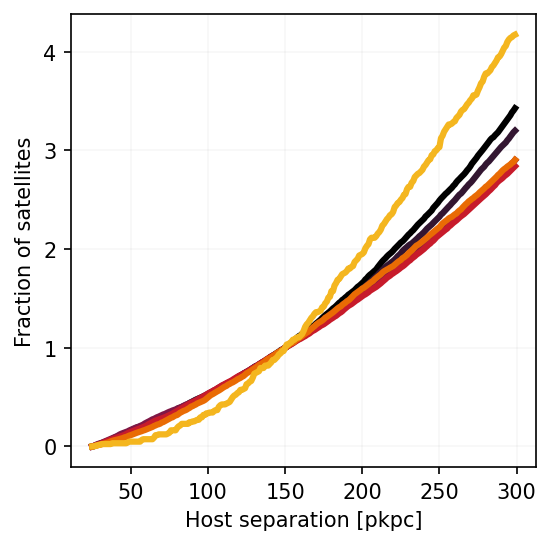

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

radius_range = np.arange(25, 300, 1)

for i, (m1, m2, color) in enumerate(
    zip(
        np.arange(9, 11.4, 0.4), 
        np.arange(9.4, 11.8, 0.4), 
        cmr.ember(np.linspace(0, 0.9, 6)), 
    )
):

    in_mass_range = (shdf.mass_NSA > 10**m1) & (shdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(shdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat / cdf_sat[np.abs((radius_range-150)).argmin()], color=color, lw=3)
    
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Fraction of satellites')

ax.grid(alpha=0.1)

# plt.savefig(fig_dir/'normalized_satellite-radial-distribution_a.png')

8141 6244
8984 5585
11468 5074
10974 3216
4195 756
512 48


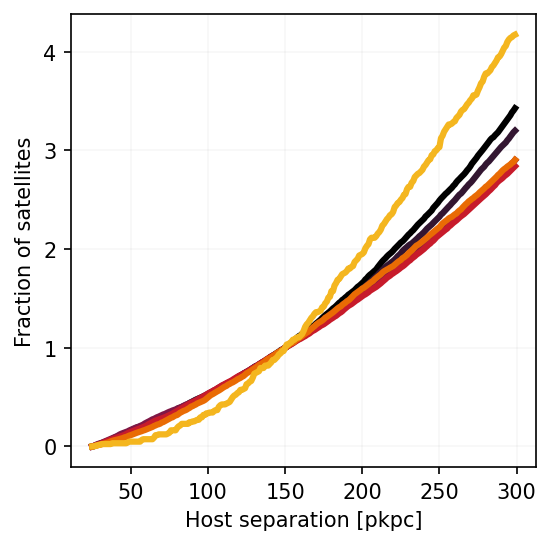

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

radius_range = np.arange(25, 300, 1)

for i, (m1, m2, color) in enumerate(
    zip(
        np.arange(9, 11.4, 0.4), 
        np.arange(9.4, 11.8, 0.4), 
        cmr.ember(np.linspace(0, 0.9, 6)), 
    )
):

    in_mass_range = (shdf.mass_NSA > 10**m1) & (shdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(shdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat / cdf_sat[np.abs((radius_range-150)).argmin()], color=color, lw=3)
    
    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Fraction of satellites')

ax.grid(alpha=0.1)


5051 4046
4944 3627
5846 3459
6772 3381
7521 2931
7350 2167
4447 981
1831 283
495 43


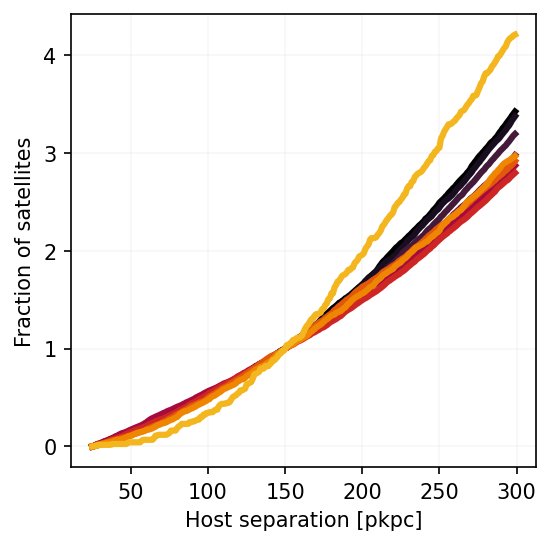

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

radius_range = np.arange(25, 300, 1)

# loop through mass bins
for i, (m1, m2, color) in enumerate(
    zip(
        np.arange(9, 11.25, 0.25), 
        np.arange(9.25, 11.5, 0.25), 
        cmr.ember(np.linspace(0, 0.9, 9)), 
    )
):

    in_mass_range = (shdf.mass_NSA > 10**m1) & (shdf.mass_NSA <= 10**m2)

    N_sats = sum(in_mass_range)
    N_hosts = sum((host_df.mass > 10**m1) & (host_df.mass < 10**m2)) # number of hosts (including those that don't contain satellites)

    print(N_sats, N_hosts)

    cdf_sat = np.array([
        sum(shdf[in_mass_range].host_distance < r) / N_hosts \
            for r in radius_range
    ])
        
    ax.plot(radius_range, cdf_sat / cdf_sat[np.abs((radius_range-150)).argmin()], color=color, lw=3)
    

    
ax.set_xlabel('Host separation [pkpc]')
ax.set_ylabel('Fraction of satellites')

ax.grid(alpha=0.1)

